In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import random
import time
from pyomo.environ import *
from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import gym
from gym import spaces, logger
from random import choice
from mlxtend.preprocessing import one_hot
import scipy.stats as stats
import math

In [4]:
class make_network(gym.Env):

    def __init__(self):

        # read technical parameters of distribution network from input excel
        self.network_data = pd.read_excel('topology.template 42M.xlsx', sheet_name=None)
        
        # bus name and voltage limits
        self.Bus_name = self.network_data['BUSES']['NAME'].values
        self.Bus_v = self.network_data['BUSES']['U'].values
        self.Bus_min_v = self.network_data['BUSES']['UMIN'].values
        self.Bus_max_v = self.network_data['BUSES']['UMAX'].values
        
        # line name, topology, reactance, resistance, current limit
        self.Line_name = self.network_data['LINES']['NAME'].values
        self.Line_from = self.network_data['LINES']['BUS1'].values
        self.Line_to = self.network_data['LINES']['BUS2'].values
        self.Line_x = self.network_data['LINES']['X'].values
        self.Line_r = self.network_data['LINES']['R'].values
        self.Line_max_i = self.network_data['LINES']['CURRENTLIMIT'].values
        
        # transformer name, topology, reactance, resistance
        self.Transformer_name = self.network_data['TRANSFORMERS']['NAME'].values
        self.Transformer_from = self.network_data['TRANSFORMERS']['BUS1'].values
        self.Transformer_to = self.network_data['TRANSFORMERS']['BUS2'].values
        self.Transformer_x = self.network_data['TRANSFORMERS']['X'].values
        self.Transformer_r = self.network_data['TRANSFORMERS']['R'].values
        
        # load name, topology, active and reactive power, shedding cost
        self.Load_name = self.network_data['LOADS']['NAME'].values
        self.Load_bus = self.network_data['LOADS']['BUS'].values
        self.Load_p = self.network_data['LOADS']['P'].values * 1000
        self.Load_q = self.network_data['LOADS']['Q'].values * 1000
        self.Load_cost = self.network_data['LOADS']['LAMBDA'].values
        
        # generator name, topology, active power capacity, reactive power capacity
        self.DG_name = self.network_data['GENERATORS']['NAME'].values
        self.DG_bus = self.network_data['GENERATORS']['BUS'].values
        self.DG_min_p = self.network_data['GENERATORS']['MINP'].values * 1000
        self.DG_max_p = self.network_data['GENERATORS']['MAXP'].values * 1000
        self.DG_min_q = self.network_data['GENERATORS']['MINQ'].values * 1000
        self.DG_max_q = self.network_data['GENERATORS']['MAXQ'].values * 1000
        
        # switch name, topology, status
        self.Switch_name = self.network_data['SWITCHES']['NAME'].values
        self.Switch_from = self.network_data['SWITCHES']['BUS1'].values
        self.Switch_to = self.network_data['SWITCHES']['BUS2'].values
        self.Switch_status = self.network_data['SWITCHES']['OPEN'].values
        
        # number of bus, line, transformer, load, generator
        self.n_bus = self.network_data['BUSES'].shape[0]
        self.n_line = self.network_data['LINES'].shape[0] 
        self.n_transformer = self.network_data['TRANSFORMERS'].shape[0] 
        self.n_load = self.network_data['LOADS'].shape[0]
        self.n_dg = self.network_data['GENERATORS'].shape[0]
        self.n_switch = self.network_data['SWITCHES'].shape[0]
        
    def ACOPF_model(self):
        
        # construct optimisation model
        model = ConcreteModel('ACOPF')
        
        # Define sets
        model.B = Set(initialize=[b for b in range(self.n_bus)], doc='Buses', ordered=True)
        model.L = Set(initialize=[l for l in range(self.n_line)], doc='Lines', ordered=True)
        model.F = Set(initialize=[f for f in range(self.n_transformer)], doc='Transformers', ordered=True)
        model.D = Set(initialize=[d for d in range(self.n_load)], doc='Loads', ordered=True)
        model.G = Set(initialize=[g for g in range(self.n_dg)], doc='Generators', ordered=True)
        model.S = Set(initialize=[s for s in range(self.n_switch)], doc='Switches', ordered=True)

        # Define variables
        model.dg_p = Var(model.G, domain=Reals) # generator active power
        model.loadshed_p = Var(model.D, domain=NonNegativeReals) # active load shedding
        model.las = Var(model.L, domain=Reals) # line active power flow sending
        model.lar = Var(model.L, domain=Reals) # line active power flow receiving
        model.lrs = Var(model.L, domain=Reals) # line reactive power flow sending
        model.lrr = Var(model.L, domain=Reals) # line reactive power flow receiving
        model.fas = Var(model.F, domain=Reals) # transformer active power flow sending
        model.far = Var(model.F, domain=Reals) # transformer active power flow receiving
        model.frs = Var(model.F, domain=Reals) # transformer reactive power flow sending
        model.frr = Var(model.F, domain=Reals) # transformer reactive power flow receiving
        model.sas = Var(model.S, domain=Reals) # switch active power flow sending
        model.sar = Var(model.S, domain=Reals) # switch active power flow receiving
        model.srs = Var(model.S, domain=Reals) # switch eactive power flow sending
        model.srr = Var(model.S, domain=Reals) # switch reactive power flow receiving
        model.volt = Var(model.B, domain=NonNegativeReals) # bus voltage**2
        model.lcurrent = Var(model.L, domain=NonNegativeReals) # line current**2
        model.fcurrent = Var(model.F, domain=NonNegativeReals) # transformer current**2
        model.grid_buy = Var(domain=NonNegativeReals)
        model.grid_sell = Var(domain=NonPositiveReals)
        model.grid_status = Var(domain=Binary)

        # generator operating constraints
        def _dg_p_UB_stay(model, g):
            return model.dg_p[g] <= self.DG_max_p[g]
        model.dg_p_UB_stay = Constraint(model.G, rule=_dg_p_UB_stay)

        def _dg_p_LB_stay(model, g):
            return model.dg_p[g] >= self.DG_min_p[g]
        model.dg_p_LB_stay = Constraint(model.G, rule=_dg_p_LB_stay)

        # load shedding constraint
        def _loadshed_p_UB_(model, d):
            return model.loadshed_p[d] <= self.Load_p[d]
        model.loadshed_p_UB_ = Constraint(model.D, rule=_loadshed_p_UB_)

        # nodal active power balance
        def _node_balance_active_(model, b): 
            return + sum(model.dg_p[g] for g in model.G if self.DG_bus[g] == self.Bus_name[b]) \
                   - sum(self.Load_p[d] for d in model.D if self.Load_bus[d] == self.Bus_name[b]) \
                   + sum(model.loadshed_p[d] for d in model.D if self.Load_bus[d] == self.Bus_name[b]) == \
                   + sum(model.las[l] for l in model.L if self.Line_from[l] == self.Bus_name[b]) \
                   + sum(model.lar[l] for l in model.L if self.Line_to[l] == self.Bus_name[b]) \
                   + sum(model.fas[f] for f in model.F if self.Transformer_from[f] == self.Bus_name[b]) \
                   + sum(model.far[f] for f in model.F if self.Transformer_to[f] == self.Bus_name[b]) \
                   + sum(model.sas[s] for s in model.S if self.Switch_from[s] == self.Bus_name[b]) \
                   + sum(model.sar[s] for s in model.S if self.Switch_to[s] == self.Bus_name[b])
        model.NodeBalanceActive_ = Constraint(model.B, rule=_node_balance_active_)

        # nodal voltage constraints
        def _volt_UB_(model, b):
            return model.volt[b] <= self.Bus_max_v[b]**2
        model.volt_UB_ = Constraint(model.B, rule=_volt_UB_)
        
        def _volt_LB_(model, b):
            return model.volt[b] >= self.Bus_min_v[b]**2
        model.volt_LB_ = Constraint(model.B, rule=_volt_LB_)
        
        print(self.Bus_max_v)
        
        #---------------------- line constraints ----------------------#
        # line current constraints
        def _line_current_UB_(model, l):
            return model.lcurrent[l] <= self.Line_max_i[l]**2
        model.line_current_UB_ = Constraint(model.L, rule=_line_current_UB_)
        
        # second order cone distflow
        def _line_equal_1(model, l):
            return model.las[l] == - model.lar[l]
        model.line_equal_1 = Constraint(model.L, rule=_line_equal_1)

        def _line_equal_2(model, l):
            return model.lrs[l] == - model.lrr[l]
        model.line_equal_2 = Constraint(model.L, rule=_line_equal_2)
        
        # line power flow constraints 
        def _line_flow_send_UB_(model, l):
            return model.lar[l] * model.lar[l] + model.lrr[l] * model.lrr[l] <= \
                   sum(model.lcurrent[l] * model.volt[b] for b in model.B if self.Line_from[l] == self.Bus_name[b])
        model.line_flow_send_UB_ = Constraint(model.L, rule=_line_flow_send_UB_)
        
        # linearized distflow
        def line_flow_(model, l):
            return (sum(model.volt[b] for b in model.B if self.Bus_name[b] == self.Line_from[l]) - \
                    sum(model.volt[b] for b in model.B if self.Bus_name[b] == self.Line_to[l])) == \
                    2 * (self.Line_r[l] * model.las[l] + self.Line_x[l] * model.lrs[l])
        model.LinePhaseActiveFlow = Constraint(model.L, rule=line_flow_)
        
        #---------------------- transformer constraints ----------------------#
        def _transformer_equal_1(model, f):
            return model.fas[f] == - model.far[f]
        model.transformer_equal_1 = Constraint(model.F, rule=_transformer_equal_1)

        def _transformer_equal_2(model, f):
            return model.frs[f] == - model.frr[f]
        model.transformer_equal_2 = Constraint(model.F, rule=_transformer_equal_2)
        
        # linearized distflow
#         def transformer_flow_(model, f):
#             return (sum(model.volt[b] for b in model.B if self.Bus_name[b] == self.Transformer_from[f]) - \
#                     sum(model.volt[b] for b in model.B if self.Bus_name[b] == self.Transformer_to[f])) >= \
#                     2 * (self.Transformer_r[f] * model.fas[f] + self.Transformer_x[f] * model.frs[f])
#         model.TransformerPhaseActiveFlow = Constraint(model.F, rule=transformer_flow_)
        
        #---------------------- switch constraints ----------------------#
        def _switch_equal_1(model, s):
            return model.sas[s] == - model.sar[s]
        model.switch_equal_1 = Constraint(model.S, rule=_switch_equal_1)

        def _switch_equal_2(model, s):
            return model.srs[s] == - model.srr[s]
        model.switch_equal_2 = Constraint(model.S, rule=_switch_equal_2)
        
        def _switch_status_connect_(model, s):
            if self.Switch_status[s] == 'OPEN':
                return model.sas[s] == 0   
            return Constraint.Skip
        model.switch_status_connect_ = Constraint(model.S, rule=_switch_status_connect_)
        
        # --------------- outage scenario -----------------
        damage = []
        def _outage_status_connect_(model, l):
            for i in range(len(damage)):
                if l == damage[i]:
                    return model.lcurrent[l] == 0
            return Constraint.Skip
        model.outage_status_connect_ = Constraint(model.L, rule=_outage_status_connect_)
        
        # -------------- objective function --------------     
        def _grid_buy_sell_(model):
            return model.dg_p[0] == model.grid_buy + model.grid_sell
        model.grid_buy_sell = Constraint(rule=_grid_buy_sell_)
        
        def _grid_buy_limit_(model):
            return model.grid_buy <= model.grid_status * self.DG_max_p[0]
        model.grid_buy_limit = Constraint(rule=_grid_buy_limit_)
        
        def _grid_sell_limit_(model):
            return model.grid_sell >= (1-model.grid_status) * self.DG_min_p[0]
        model.grid_sell_limit = Constraint(rule=_grid_sell_limit_)
        
        def _obj_(model):
            return sum(self.Load_cost[d] * model.loadshed_p[d] for d in model.D) + model.grid_buy * 0.1
        model.objective = Objective(rule=_obj_, sense=minimize)

        return model

In [5]:
Network = make_network()
inst = Network.ACOPF_model()
solver = SolverFactory ('gurobi', tee=True)
result = solver.solve (inst, tee=True)
print(value(inst.objective))

C:\Users\Dawei Qiu\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


[22.   22.   22.   22.   22.   22.   22.   22.    0.44 22.   22.   22.
 22.   22.   22.   22.   22.    0.44 22.   22.   22.   22.    0.44 22.
  0.44 22.   22.   22.   22.   22.   22.   22.   22.   22.   22.   22.
 22.   22.   22.   22.   22.   22.   22.   22.    0.44 22.   22.   22.
 22.   22.   22.   22.   22.    0.44 22.   22.   22.   22.   22.   22.
 22.   22.   22.   22.   22.   22.   22.   22.   22.   22.   22.   22.
 22.   22.   22.   22.   22.   22.   22.   22.   22.   22.   22.   22.
 22.   22.   22.   22.    0.44 22.   22.   22.   22.   22.   22.   22.
 22.   22.   22.   22.   22.   22.   22.   22.   22.   22.   22.   22.
 22.   22.   22.   22.   22.   22.   22.   22.   22.   22.   22.   22.
 22.   22.   22.   22.   22.  ]
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16
Read LP format model from file C:\Users\DAWEIQ~1\AppData\Local\Temp\tmpvx4p3jlq.pyomo.lp
Reading time = 0.02 seconds
x797: 927 rows, 790 columns, 1684 nonzeros
Gurobi 

In [83]:
Load_SP = np.zeros(Network.n_load)
Load_P = np.zeros(Network.n_load)
DG_P = np.zeros(Network.n_dg)
LineFlow_P = np.zeros(Network.n_line)
LineCurrent = np.zeros(Network.n_line)
TransformerFlow_P = np.zeros(Network.n_transformer)
SwitchFlow_P = np.zeros(Network.n_switch)
BusVoltage = np.zeros(Network.n_bus)

for d in inst.D:
    Load_SP[d] = value(inst.loadshed_p[d])
    Load_P[d] = Network.Load_p[d] - Load_SP[d]
for g in inst.G:
    DG_P[g] = value(inst.dg_p[g])
for l in inst.L:
    LineFlow_P[l] = value(inst.las[l])
    LineCurrent[l] = value(inst.lcurrent[l])**0.5
for f in inst.F:
    TransformerFlow_P[f] = value(inst.fas[f])
for s in inst.S:
    SwitchFlow_P[s] = value(inst.sas[s])
for b in inst.B:
    BusVoltage[b] = value(inst.volt[b])**0.5

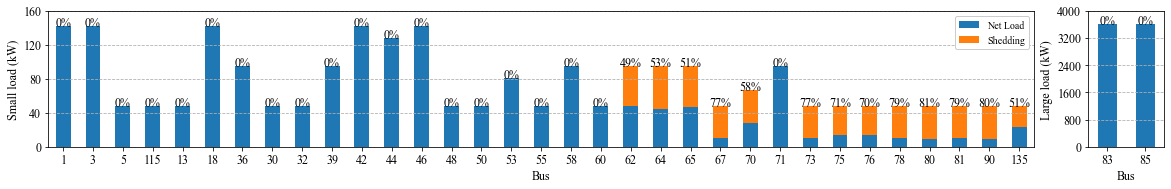

P demand: 9228.991313720051
P shedding: 499.0086862799493


In [84]:
LoadP_percent_shed = [100*(SP/P) for SP, P in zip(Load_SP, Network.Load_p)]
Small_Load_base, Small_Load, Small_Load_Shed, Small_Load_Shed_Pec = [], [], [], []
Large_Load_base, Large_Load, Large_Load_Shed, Large_Load_Shed_Pec = [], [], [], []
for d in range(len(Network.Load_p)):
    if Network.Load_p[d] >= 3000:
        Large_Load_base.append(Network.Load_p[d])
        Large_Load.append(Load_P[d])
        Large_Load_Shed.append(Load_SP[d])
        Large_Load_Shed_Pec.append(100*(Load_SP[d]/Network.Load_p[d]))
    else:
        Small_Load_base.append(Network.Load_p[d])
        Small_Load.append(Load_P[d])
        Small_Load_Shed.append(Load_SP[d])
        Small_Load_Shed_Pec.append(100*(Load_SP[d]/Network.Load_p[d]))
        
# plot figure
fig = plt.figure(figsize=(20,2.5))
grid = plt.GridSpec(1,35, wspace=2, hspace=0)
x0 = range(len(Small_Load_base))
x1 = range(len(Large_Load_base))
width = 0.5
space = 0.5
text1 = 10
text2 = 12
text3 = 14
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}

# plot small load
ax = fig.add_subplot(grid[0,0:31])
bar1 = plt.bar(x0, Small_Load, width, label='Net Load')
bar2 = plt.bar(x0, Small_Load_Shed, width, bottom=Small_Load, label='Shedding')
# function to add value labels
def addlabels(h,y):
    for i in range(len(Small_Load)):
        plt.text(i, h[i], f"{y[i]:.0f}%", ha='center', fontname='Times New Roman', fontsize=text2)
addlabels(Small_Load_base, Small_Load_Shed_Pec)
plt.grid(which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,32,33), fontname = "Times New Roman")
plt.yticks(np.linspace(0,160,5), fontname = "Times New Roman")
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32],
           [1,3,5,115,13,18,36,30,32,39,42,44,46,48,50,53,55,58,60,62,64,65,67,70,71,73,75,76,78,80,81,90,135])
plt.xlim(-0.5,32.5)
plt.ylabel('Small load (kW)', font2)
plt.xlabel('Bus', font2)
legend = plt.legend(loc='upper right', prop=font1, labelspacing=space, framealpha=1, ncol=1, bbox_to_anchor=(1,1))

# plot large load
ax = fig.add_subplot(grid[0,-3:])
bar1 = plt.bar(x1, Large_Load, width, label='Net')
bar2 = plt.bar(x1, Large_Load_Shed, width, bottom=Large_Load, label='Shed')
# function to add value labels
def addlabels(h,y):
    for i in range(len(Large_Load)):
        plt.text(i, h[i], f"{y[i]:.0f}%", ha='center', fontname='Times New Roman', fontsize=text2)
addlabels(Large_Load_base, Large_Load_Shed_Pec)
plt.grid(which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,1,2), fontname="Times New Roman")
plt.yticks(np.linspace(0,4000,6), fontname="Times New Roman")
plt.xticks([0,1],[83,85])
plt.xlim(-0.5,1.5)
plt.ylabel('Large load (kW)', font2)
plt.xlabel('Bus', font2)
plt.savefig('Base_Load.jpg', bbox_inches='tight', dpi = 900)
plt.show()

print('P demand:', np.sum(Load_P))
print('P shedding:', np.sum(Load_SP))

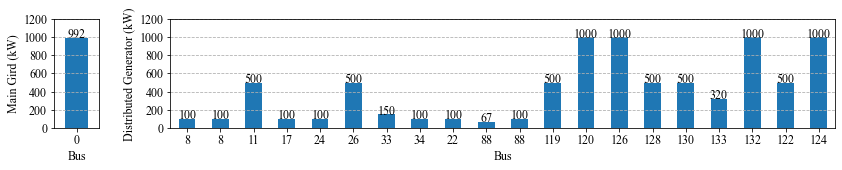

P supply: 9228.991313716031
Gen 8: 100.0
Gen 8: 99.9999996891438
Gen 24: 99.99999968914446
Gen 88: 67.0
Gen 88: 99.99999996891432


In [86]:
fig = plt.figure(figsize=(14,2))
grid = plt.GridSpec(1,21, wspace=5, hspace=0)
x0 = range(1)
x1 = range(Network.n_dg-1)
width = 0.5
space = 0.5
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}

# plot grid power
ax = fig.add_subplot(grid[0,:2])
bar1 = plt.bar(x0, DG_P[0], width)
plt.text(0, DG_P[0], f"{DG_P[0]:.0f}", ha='center', fontname='Times New Roman', fontsize=text2)
plt.grid(which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,0,1), fontname = "Times New Roman")
plt.yticks(np.linspace(0,1200,7), fontname = "Times New Roman")
plt.xticks([0],[0])
plt.xlim(-0.5,0.5)
plt.ylim(0,1200)
plt.ylabel('Main Gird (kW)', font2)
plt.xlabel('Bus', font2)

ax = fig.add_subplot(grid[0,-18:])
bar1 = plt.bar(x1, DG_P[-20:], width)
def addlabels(h,y):
    for i in range(len(DG_P[-20:])):
        plt.text(i, DG_P[-20:][i], f"{DG_P[-20:][i]:.0f}", ha='center', fontname='Times New Roman', fontsize=text2)
addlabels(DG_P[-20:], DG_P[-20:])
plt.grid(which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,19,20), fontname = "Times New Roman")
plt.yticks(np.linspace(0,1200,7), fontname = "Times New Roman")
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
           [8,8,11,17,24,26,33,34,22,88,88,119,120,126,128,130,133,132,122,124])
plt.xlim(-0.5,19.5)
plt.ylim(0,1200)
plt.ylabel('Distributed Generator (kW)', font2)
plt.xlabel('Bus', font2)
plt.savefig('Base_Gen.jpg', bbox_inches='tight', dpi = 900)
plt.show()

print('P supply:', np.sum(DG_P))
print('Gen 8:', np.sum(DG_P[1]))
print('Gen 8:', np.sum(DG_P[2]))
print('Gen 24:', np.sum(DG_P[5]))
print('Gen 88:', np.sum(DG_P[10]))
print('Gen 88:', np.sum(DG_P[11]))

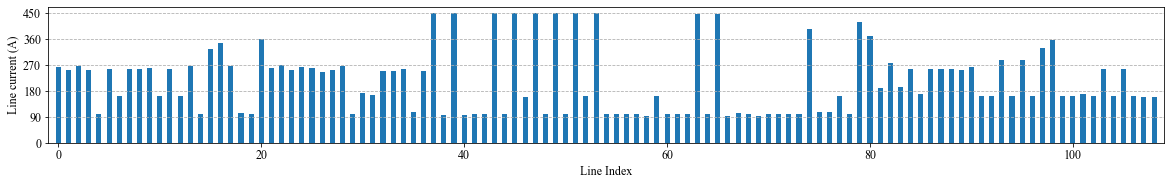

Line 46: Bus 45-47: 447.9999923587613
Line 54: Bus 54-65: 447.99203846366163


In [76]:
fig = plt.figure(figsize=(20,2.5))
x = range(Network.n_line)
width = 0.5
space = 0.5
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}
# plot active generation
bar1 = plt.bar(x, LineCurrent, width)
plt.grid(which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(fontname = "Times New Roman")
plt.yticks(np.linspace(0,450,6), fontname = "Times New Roman")
plt.xlim(-1,109)
plt.ylabel('Line current (A)', font2)
plt.xlabel('Line Index', font2)
plt.show()
print('Line 46: Bus 45-47:', LineCurrent[45])
print('Line 54: Bus 54-65:', LineCurrent[53])

C:\Users\Dawei Qiu\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


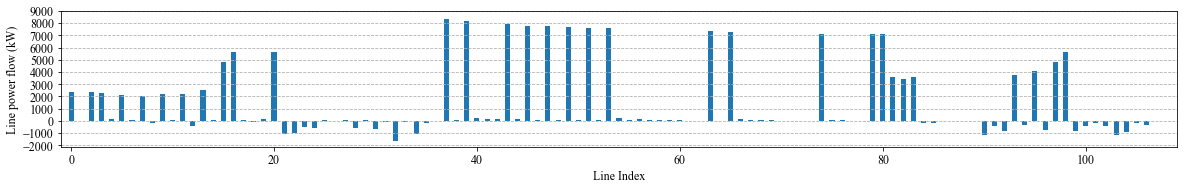

Line 46: Bus 45-47: 7793.741702648075
Max Line 46: Bus 45-47: 9856


In [62]:
fig = plt.figure(figsize=(20,2.5))
x = range(Network.n_line)
width = 0.5
space = 0.5
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}
# plot active generation
bar1 = plt.bar(x, LineFlow_P, width)
plt.grid(b=None, which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(fontname = "Times New Roman")
plt.yticks(np.linspace(-2000,9000,12), fontname = "Times New Roman")
plt.xlim(-1,109)
plt.ylabel('Line power flow (kW)', font2)
plt.xlabel('Line Index', font2)
plt.show()
print('Line 46: Bus 45-47:', LineFlow_P[45])
print('Max Line 46: Bus 45-47:', 448*22)

C:\Users\Dawei Qiu\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


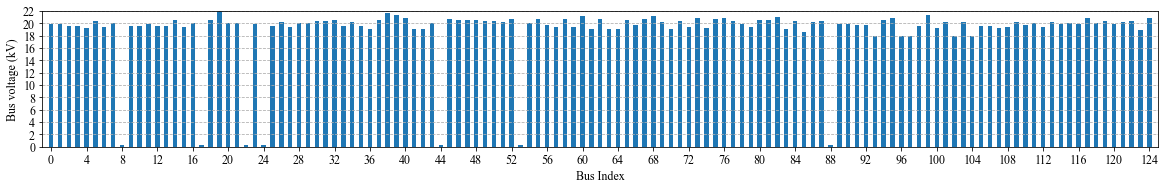

Bus 6: 19.316114833928914
Bus 7: 20.077781352289467
Bus 86: 20.209642278984994
Bus 87: 20.36689089861754


In [63]:
fig = plt.figure(figsize=(20,2.5))
x = range(Network.n_bus)
width = 0.5
space = 0.5
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}
# plot active generation
bar1 = plt.bar(x, BusVoltage, width)
plt.grid(b=None, which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,124,32), fontname = "Times New Roman")
plt.yticks(np.linspace(0,22,12), fontname = "Times New Roman")
plt.xlim(-1,125)
plt.ylim(0,22)
plt.ylabel('Bus voltage (kV)', font2)
plt.xlabel('Bus Index', font2)
plt.show()

print('Bus 6:', BusVoltage[6])
print('Bus 7:', BusVoltage[7])
print('Bus 86:', BusVoltage[86])
print('Bus 87:', BusVoltage[87])

C:\Users\Dawei Qiu\anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


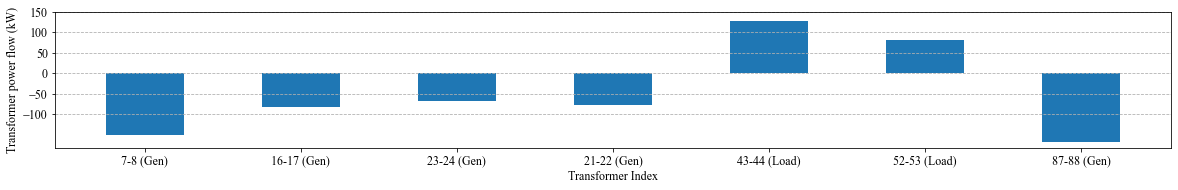

-68.01878429307499


In [64]:
fig = plt.figure(figsize=(20,2.5))
x = range(Network.n_transformer)
width = 0.5
space = 0.5
text1 = 10
text2 = 12
font1 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text1}
font2 = {'family': 'Times New Roman', 'weight': 'normal', 'size': text2}
# plot active generation
bar1 = plt.bar(x, TransformerFlow_P, width)
plt.grid(b=None, which='major', linestyle='--', axis='y')
plt.tick_params(labelsize = text2)
plt.xticks(np.linspace(0,6,7), fontname = "Times New Roman")
plt.yticks(np.linspace(-100,150,6), fontname = "Times New Roman")
plt.xticks([0,1,2,3,4,5,6],['7-8 (Gen)','16-17 (Gen)','23-24 (Gen)','21-22 (Gen)','43-44 (Load)','52-53 (Load)','87-88 (Gen)'])
plt.ylabel('Transformer power flow (kW)', font2)
plt.xlabel('Transformer Index', font2)
plt.show()
print(TransformerFlow_P[2])

In [65]:
SwitchFlow_P

array([   0.        , 5661.52349559,    0.        ,    0.        ,
       7071.90747713, 7071.90747713,    0.        ,    0.        ])